## Lung Cancer Detection

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Loading and Working on the Dataset

In [2]:
# Load Dataset
data_dir = "lung-image-sets"

In [3]:
# extra code to save the figures as high-res PNGs for the book
from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

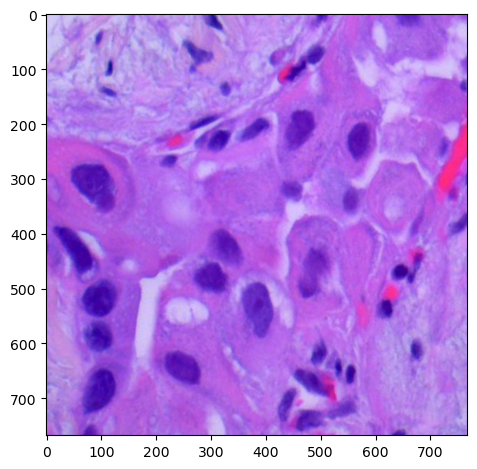

In [4]:
import matplotlib.image as mping
test_image = "lung-image-sets/Adenocarcinoma/lungaca1.jpeg"
img = mping.imread(test_image)
plt.imshow(img)
save_fig("sample_adenocarcinoma")

In [5]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Splitting the dataset into training and validation sets

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


In [8]:
# class names

class_names = train_ds.class_names
class_names

['Adenocarcinoma', 'Benign', 'Squamous cell carcinoma']

## Data Visualization

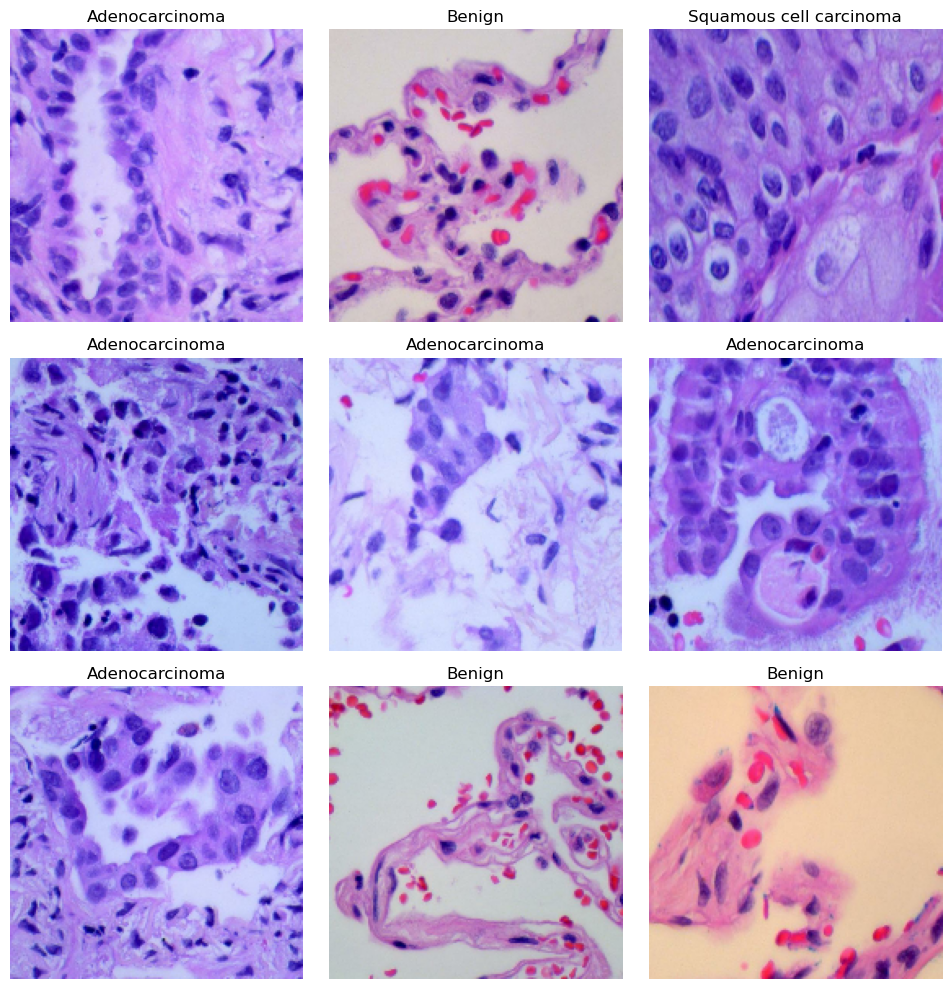

In [9]:
# Here are the first nine images from the training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        save_fig("sample_training_images")

In [10]:
# manually iterate over the dataset and retreive batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The image_batch is tensor of shape (32,180,180,3). This is a batch of size(180*180*3), the last dimension refers to color channelsRGB). the labels_batch is a tensor of shape(32), these are the corresponding labels to the 32 images

## Configure the Dataset for Performance

Dataset.cache - keeps the images in memory after they are loaded off disk during the first epoch.

Dataset.prefetch - overlaps data preprocessing and model execution while trainig

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize data

In [12]:
normalization_layer = layers.Rescaling(1./255)

## Prevent Overfitting

#### Data Augmentation

Data augmentation takes the approach of generating additional training data from existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

Visualize a few augmented examples by applying data augmentation to the same image several times

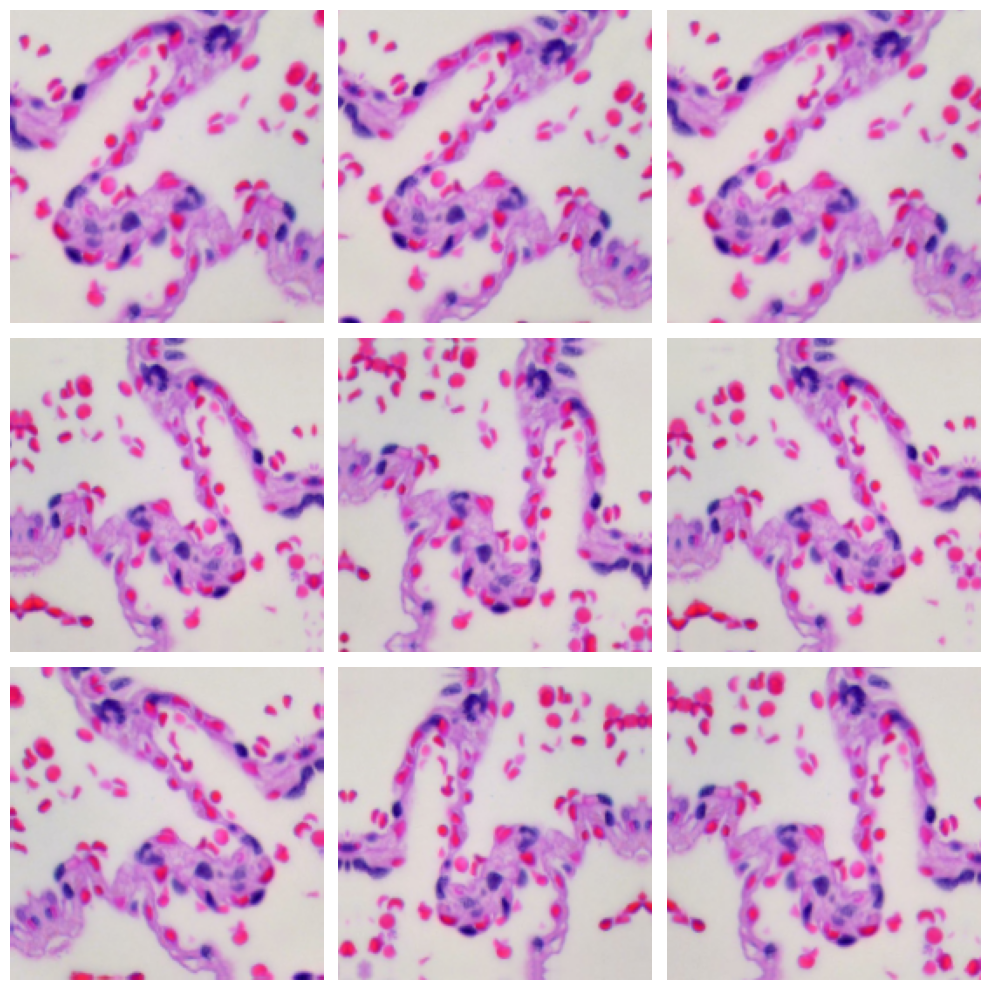

In [14]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis("off")
        save_fig("sample_augmented_images")

#### Dropout

Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [15]:
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

## Compile and Train the Model

In [16]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [18]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/5
375/375 [==============================] - 879s 2s/step - loss: 0.4092 - accuracy: 0.8203 - val_loss: 0.3204 - val_accuracy: 0.8623
Epoch 2/5
375/375 [==============================] - 1061s 3s/step - loss: 0.2427 - accuracy: 0.9020 - val_loss: 0.1943 - val_accuracy: 0.9170
Epoch 3/5
375/375 [==============================] - 933s 2s/step - loss: 0.1938 - accuracy: 0.9218 - val_loss: 0.1680 - val_accuracy: 0.9393
Epoch 4/5
375/375 [==============================] - 891s 2s/step - loss: 0.1609 - accuracy: 0.9364 - val_loss: 0.1690 - val_accuracy: 0.9223
Epoch 5/5
375/375 [==============================] - 1188s 3s/step - loss: 0.1444 - accuracy: 0.9424 - val_loss: 0.1235 - val_accuracy: 0.9523


## Visualizing the Training Results

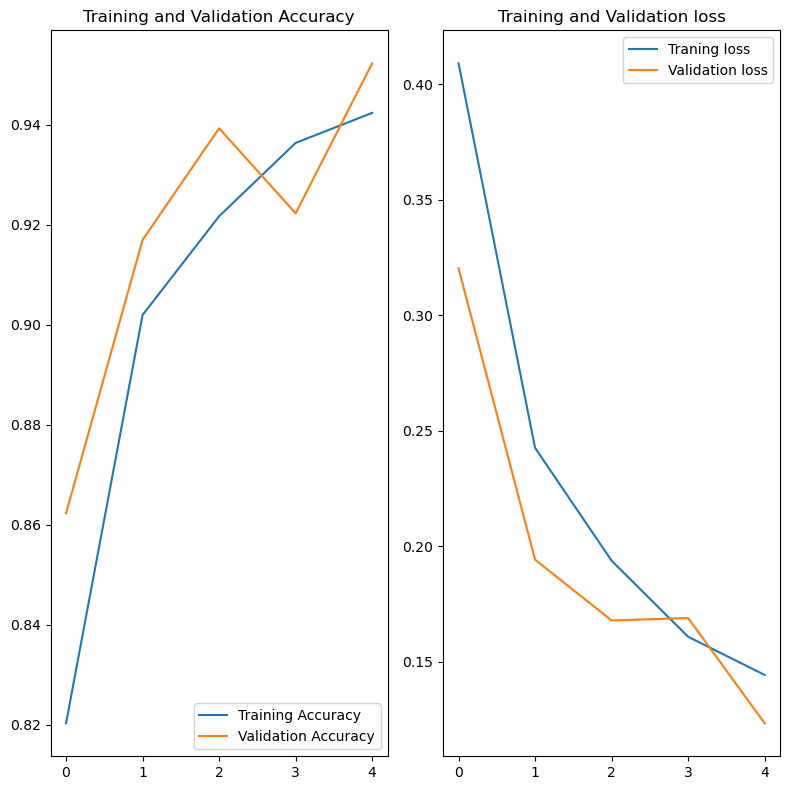

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Traning loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")
save_fig("training_and_validation_accuracy_and_loss")
plt.show()

In [20]:
# predict on new data
img = tf.keras.utils.load_img(
    "lung-cancer-data/test3.png", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)